In [18]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [19]:
# !nvidia-smi

In [20]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'drive/My Drive/chest_xray/train'
valid_path = 'drive/My Drive/chest_xray/test'


In [21]:
# # Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# # Here we will be using imagenet weights

# vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


# Import the Vgg 19 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# # Import the InceptionV3 library as shown below and add preprocessing layer to the front of VGG
# # Here we will be using imagenet weights

# vgg = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [22]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [23]:
# useful for getting number of output classes
folders = glob('drive/My Drive/chest_xray/train/*')

In [24]:
folders

['drive/My Drive/chest_xray/train/PNEUMONIA',
 'drive/My Drive/chest_xray/train/NORMAL']

In [25]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [26]:
# If only 2 categories go with sigmoid, if multiple go with softmax
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [27]:
# view the structure of the model
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [28]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [29]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [30]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('drive/My Drive/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [31]:
test_set = test_datagen.flow_from_directory('drive/My Drive/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [32]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
163/163 [==============================] - 2367s 15s/step - loss: 0.2738 - accuracy: 0.9045 - val_loss: 0.4896 - val_accuracy: 0.8317
Epoch 2/10
163/163 [==============================] - 110s 675ms/step - loss: 0.1308 - accuracy: 0.9490 - val_loss: 0.6003 - val_accuracy: 0.8205
Epoch 3/10
163/163 [==============================] - 111s 684ms/step - loss: 0.1119 - accuracy: 0.9565 - val_loss: 0.3314 - val_accuracy: 0.8926
Epoch 4/10
163/163 [==============================] - 112s 690ms/step - loss: 0.0937 - accuracy: 0.9620 - val_loss: 0.3546 - val_accuracy: 0.8894
Epoch 5/10
163/163 [==============================] - 113s 693ms/step - loss: 0.0978 - accuracy: 0.9630 - val_loss: 0.3806 - val_accuracy: 0.8702
Epoch 6/10
163/163 [==============================] - 114s 697ms/step - loss: 0.1597 - accuracy: 0.9473 - val_loss: 0.4063 - val_accuracy: 0.9022
Epoch 7/10
163/163 [==============================] - 118s 725ms/step - loss: 0.0795 - accuracy: 0.9695 - val_loss: 0.3517 - 

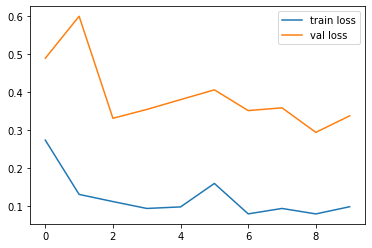

In [33]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

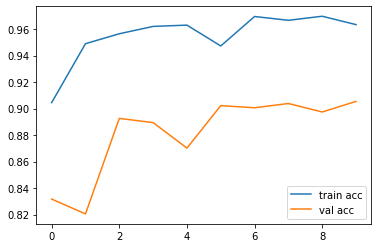

In [34]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

In [35]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

model.save('drive/My Drive/chest_xray/chestxray_vgg16.h5')